In [115]:
import warnings
import pandas as pd
import numpy as np
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [116]:
df_path = 'C:\imbalance_forecast\data\df_nord_h_project.csv'
df_nord = pd.read_csv(df_path, index_col=0, parse_dates=True)

# Check for duplicate timestamps in the index and remove duplicates
df_nord = df_nord[~df_nord.index.duplicated(keep='first')]
df_nord.tail(20)

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\samueledelia\AppData\Local\Temp\3\ipykernel_8944\541087384.py:1: SyntaxWarning: invalid escape sequence '\i'
  df_path = 'C:\imbalance_forecast\data\df_nord_h_project.csv'


,SBIL_MWH,SBIL_MWH_lag1,SBIL_MWH_lag2,SBIL_MWH_lag3,SBIL_MWH_lag24,MGP_NORD_PURCHASES,MGP_NORD_SALES,FORECAST_TOTAL_LOAD_MW,TOTAL_LOAD_MW,UNBALANCE_IDRO-NON-PROGRAMMABILE_MACRONORD,UNBALANCE_IDRO-PROGRAMMABILE_NORD,UNBALANCE_SOLARE_NORD
ORAINI,,,,,,,,,,,,
2024-12-03 04:00:00,NaN,NaN,NaN,NaN,NaN,14818.291,11092.115,NaN,NaN,NaN,NaN,NaN
2024-12-03 05:00:00,NaN,NaN,NaN,NaN,NaN,15822.319,12058.629,NaN,NaN,NaN,NaN,NaN
2024-12-03 06:00:00,NaN,NaN,NaN,NaN,NaN,19307.601,15396.114,NaN,NaN,NaN,NaN,NaN
2024-12-03 07:00:00,NaN,NaN,NaN,NaN,NaN,22857.210,20209.595,NaN,NaN,NaN,NaN,NaN
2024-12-03 08:00:00,NaN,NaN,NaN,NaN,NaN,25228.884,22366.966,NaN,NaN,NaN,NaN,NaN
2024-12-03 09:00:00,NaN,NaN,NaN,NaN,NaN,25530.621,22468.822,NaN,NaN,NaN,NaN,NaN
2024-12-03 10:00:00,NaN,NaN,NaN,NaN,NaN,25145.785,21167.485,NaN,NaN,NaN,NaN,NaN
2024-12-03 11:00:00,NaN,NaN,NaN,NaN,NaN,25008.880,20481.266,NaN,NaN,NaN,NaN,NaN
2024-12-03 12:00:00,NaN,NaN,NaN,NaN,NaN,23452.021,19221.623,NaN,NaN,NaN,NaN,NaN


In [117]:
# Define past, future, and present covariates
past_covariates = df_nord[['TOTAL_LOAD_MW', 'FORECAST_TOTAL_LOAD_MW']]

future_covariates = df_nord[['MGP_NORD_PURCHASES', 'MGP_NORD_SALES']]

present_covariates = df_nord[['SBIL_MWH_lag1', 'SBIL_MWH_lag2', 'SBIL_MWH_lag3', 'SBIL_MWH_lag24', 'UNBALANCE_IDRO-NON-PROGRAMMABILE_MACRONORD', 'UNBALANCE_IDRO-PROGRAMMABILE_NORD', 'UNBALANCE_SOLARE_NORD']]
target = df_nord['SBIL_MWH']

In [118]:
# Now separate the features and target again
X = df_nord.drop(columns=['SBIL_MWH'])
y = df_nord['SBIL_MWH']

# Make sure to drop rows with NaN values that may have resulted from the shift
X = X.dropna()
y = y.loc[X.index]  # Align y with X after dropping NaNs

In [119]:
# Convert to numpy arrays
X_past = X[['TOTAL_LOAD_MW', 'FORECAST_TOTAL_LOAD_MW']].values

X_future = X[['MGP_NORD_PURCHASES', 'MGP_NORD_SALES']].values

X_present = X[['SBIL_MWH_lag1', 'SBIL_MWH_lag2', 'SBIL_MWH_lag3', 'SBIL_MWH_lag24', 'UNBALANCE_IDRO-NON-PROGRAMMABILE_MACRONORD', 'UNBALANCE_IDRO-PROGRAMMABILE_NORD', 'UNBALANCE_SOLARE_NORD']].values
y = y.values

# Split the data into training and testing sets
X_past_train, X_past_test, X_future_train, X_future_test, X_present_train, X_present_test, y_train, y_test = train_test_split(
    X_past, X_future, X_present, y, test_size=0.15, shuffle=False)

In [120]:
# Normalize the data
scaler_X_past = StandardScaler()
scaler_X_future = StandardScaler()
scaler_X_present = StandardScaler()
scaler_y = StandardScaler()

# Reshape for normalization (past covariates)
X_past_train = scaler_X_past.fit_transform(X_past_train)
X_past_test = scaler_X_past.transform(X_past_test)

# Normalize future and present covariates directly
X_future_train = scaler_X_future.fit_transform(X_future_train)
X_future_test = scaler_X_future.transform(X_future_test)
X_present_train = scaler_X_present.fit_transform(X_present_train)
X_present_test = scaler_X_present.transform(X_present_test)

# Normalize the target variable
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Combine past, present, and future covariates for the final model input
X_train = np.concatenate([X_past_train, X_future_train, X_present_train], axis=1)
X_test = np.concatenate([X_past_test, X_future_test, X_present_test], axis=1)

In [121]:
# Define the MLP Model
model1 = Sequential()

# Input layer + First hidden layer with L2 regularization
model1.add(Dense(4, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.1)))

# Second hidden layer with L2 regularization
model1.add(Dense(4, activation='relu', kernel_regularizer=l2(0.1)))

# Output layer (single neuron for regression)
model1.add(Dense(1))

# Adam optimizer with initial learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Compile the model
model1.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model1.fit(X_train, y_train, epochs=100, batch_size=512, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100


c:\Users\samueledelia\.conda\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 2.1625 - mae: 0.7927 - val_loss: 1.8835 - val_mae: 0.6540
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.1169 - mae: 0.7780 - val_loss: 1.8617 - val_mae: 0.6511
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.0666 - mae: 0.7666 - val_loss: 1.8411 - val_mae: 0.6483
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.0450 - mae: 0.7687 - val_loss: 1.8209 - val_mae: 0.6453
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.9960 - mae: 0.7549 - val_loss: 1.8012 - val_mae: 0.6419
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.0139 - mae: 0.7629 - val_loss: 1.7824 - val_mae: 0.6389
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.9816 - mae: 0.7557 - val_loss: 1.7641 - val_mae: 0.6358
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.9401 - mae: 0.7432 - val_loss: 1.7467 - val_mae: 0.6328
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.8976 - mae: 0.7369 - val

In [122]:
# Evaluate the model on test data
y_pred = model1.predict(X_test)

# Inverse transform predictions and true values to get the original scale
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Calculate additional metrics
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2 = r2_score(y_test_orig, y_pred_orig)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Mean Absolute Error: 286.4052
Root Mean Squared Error: 365.5805
R-squared: 0.2567


In [123]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

y_pred_binary = np.where(y_pred >= 0, 1, -1)  # Convert predicted values to binary classes

y_test_binary = np.where(y_test >= 0, 1, -1)  # Assuming the threshold is 0 for classifying into +1 or -1

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary).ravel()

# Calculate Precision, Recall, Accuracy, F1 Score
P = precision_score(y_test_binary, y_pred_binary, pos_label=1)
R = recall_score(y_test_binary, y_pred_binary, pos_label=1)
Acc = accuracy_score(y_test_binary, y_pred_binary)
F1 = f1_score(y_test_binary, y_pred_binary, pos_label=1)

# Print results
print(f'Confusion Matrix:\nTN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')
print(f'Precision (P): {P:.4f}')
print(f'Recall (R): {R:.4f}')
print(f'Accuracy (Acc): {Acc:.4f}')
print(f'F1 Score (F1): {F1:.4f}')

Confusion Matrix:
TN: 194, FP: 26, FN: 32, TP: 93
Precision (P): 0.7815
Recall (R): 0.7440
Accuracy (Acc): 0.8319
F1 Score (F1): 0.7623


Confusion Matrix:
[[153  41]
 [ 23 128]]
Class -1:
  Precision: 0.8693
  Recall: 0.7887
  F1 Score: 0.8270
Class 1:
  Precision: 0.7574
  Recall: 0.8477
  F1 Score: 0.8000
Accuracy (Acc): 0.8145


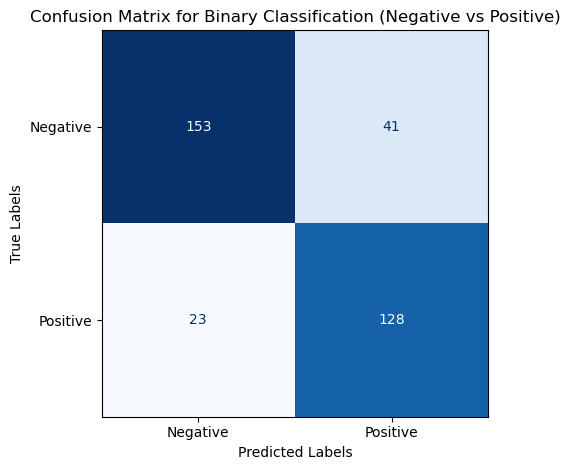

In [124]:
# Inverse transform predictions and true values to get the original scale
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Function to classify into 2 classes based on the sign
def classify_into_classes(y):
    if y < 0:
        return -1  # Negative values
    else:
        return 1  # Positive values

# Apply classification function to actual and predicted values
y_pred_classes = np.array([classify_into_classes(y) for y in y_pred_orig])
y_test_classes = np.array([classify_into_classes(y) for y in y_test_orig])

# Calculate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Calculate Precision, Recall, Accuracy, F1 Score for each class
P = precision_score(y_test_classes, y_pred_classes, average=None, labels=[-1, 1])
R = recall_score(y_test_classes, y_pred_classes, average=None, labels=[-1, 1])
Acc = accuracy_score(y_test_classes, y_pred_classes)
F1 = f1_score(y_test_classes, y_pred_classes, average=None, labels=[-1, 1])

# Print Confusion Matrix
print("Confusion Matrix:")
print(cm)

# Print classification metrics for each class
for class_label, precision, recall, f1 in zip([-1, 1], P, R, F1):
    print(f'Class {class_label}:')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall: {recall:.4f}')
    print(f'  F1 Score: {f1:.4f}')

# Print overall accuracy
print(f'Accuracy (Acc): {Acc:.4f}')

# Plot the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues', values_format='g', colorbar=False)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Binary Classification (Negative vs Positive)')
plt.tight_layout()
plt.show()


c:\Users\samueledelia\.conda\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[  0 108  13   2]
 [  0  45  24   2]
 [  0  18  37  15]
 [  0   5  34  42]]
Class -2:
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class -1:
  Precision: 0.2557
  Recall: 0.6338
  F1 Score: 0.3644
Class 1:
  Precision: 0.3426
  Recall: 0.5286
  F1 Score: 0.4157
Class 2:
  Precision: 0.6885
  Recall: 0.5185
  F1 Score: 0.5915
Accuracy (Acc): 0.3594


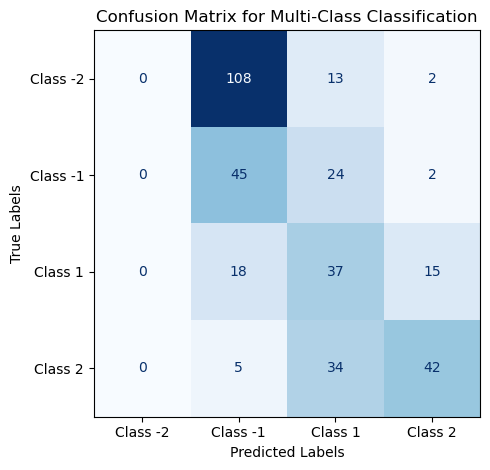

In [125]:
# Inverse transform predictions and true values to get the original scale
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Function to classify into 4 classes
def classify_into_classes(y):
    if y < 0:
        if y >= -250:
            return -1  # y in [-100, 0)
        else:
            return -2  # y < -100
    elif y < 250:
        return 1  # y in [0, 100)
    else:
        return 2  # y >= 100

# Apply classification function to actual and predicted values
y_pred_classes = np.array([classify_into_classes(y) for y in y_pred_orig])
y_test_classes = np.array([classify_into_classes(y) for y in y_test_orig])

# Calculate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Calculate Precision, Recall, Accuracy, F1 Score for each class
P = precision_score(y_test_classes, y_pred_classes, average=None, labels=[-2, -1, 1, 2])
R = recall_score(y_test_classes, y_pred_classes, average=None, labels=[-2, -1, 1, 2])
Acc = accuracy_score(y_test_classes, y_pred_classes)
F1 = f1_score(y_test_classes, y_pred_classes, average=None, labels=[-2, -1, 1, 2])

# Print Confusion Matrix
print("Confusion Matrix:")
print(cm)

# Print classification metrics for each class
for class_label, precision, recall, f1 in zip([-2, -1, 1, 2], P, R, F1):
    print(f'Class {class_label}:')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall: {recall:.4f}')
    print(f'  F1 Score: {f1:.4f}')

# Print overall accuracy
print(f'Accuracy (Acc): {Acc:.4f}')

# Plot the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class -2", "Class -1", "Class 1", "Class 2"])
disp.plot(cmap='Blues', values_format='g', colorbar=False)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Multi-Class Classification')
plt.tight_layout()
plt.show()

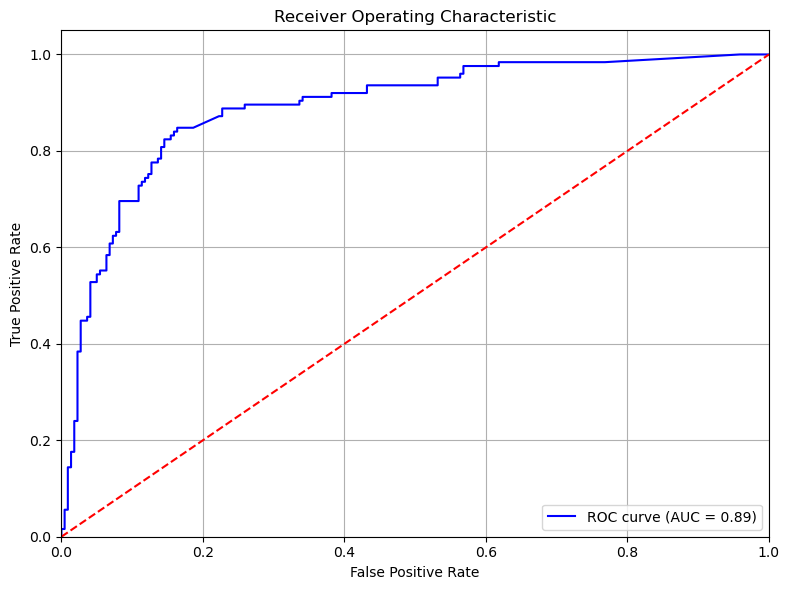

AUC: 0.89


In [126]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_orig)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

# Print AUC
print(f"AUC: {roc_auc:.2f}")

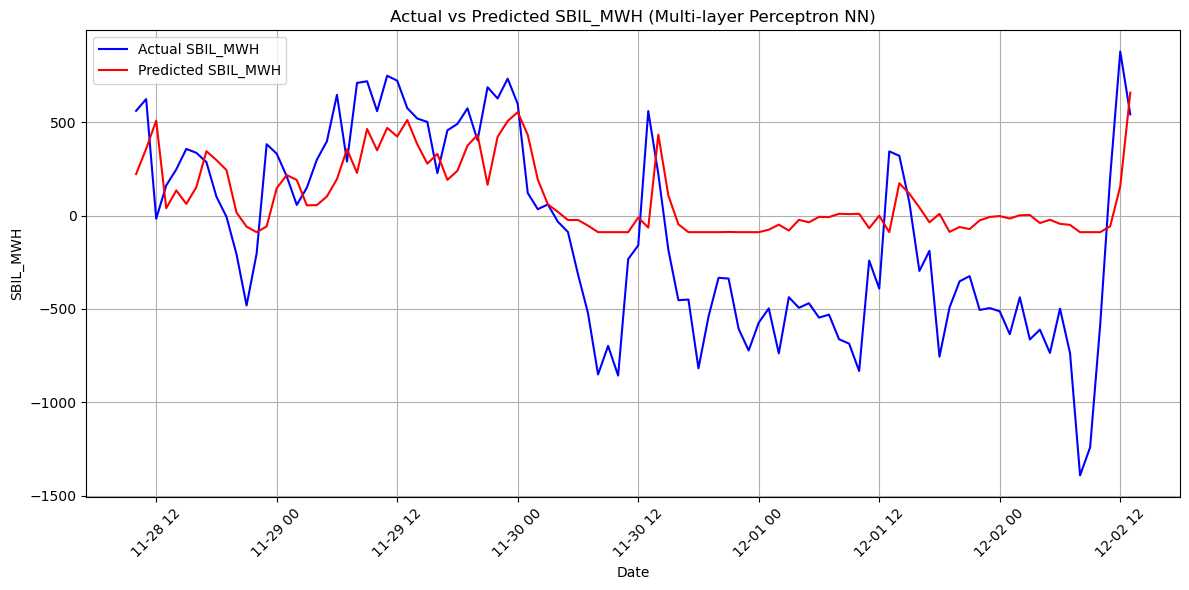

In [127]:
# Specify the number of most recent entries to plot
n = 100

# Inverse transform predictions and target for plotting (last n entries)
y_test_last_n = scaler_y.inverse_transform(y_test[-n:].reshape(-1, 1)).flatten()
y_pred_last_n = scaler_y.inverse_transform(y_pred[-n:].reshape(-1, 1)).flatten()

# Filter the rows where the target 'SBIL_MWH' is not NaN
valid_target_index = df_nord[~df_nord['SBIL_MWH'].isna()].index

# Get the last 'n' timestamps from the valid target index
dates_last_n = valid_target_index[-n:]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dates_last_n, y_test_last_n, label='Actual SBIL_MWH', color='blue')
plt.plot(dates_last_n, y_pred_last_n, label='Predicted SBIL_MWH', color='red')
plt.title('Actual vs Predicted SBIL_MWH (Multi-layer Perceptron NN)')
plt.xlabel('Date')
plt.ylabel('SBIL_MWH')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

<h3> Let's predict the future </h3>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


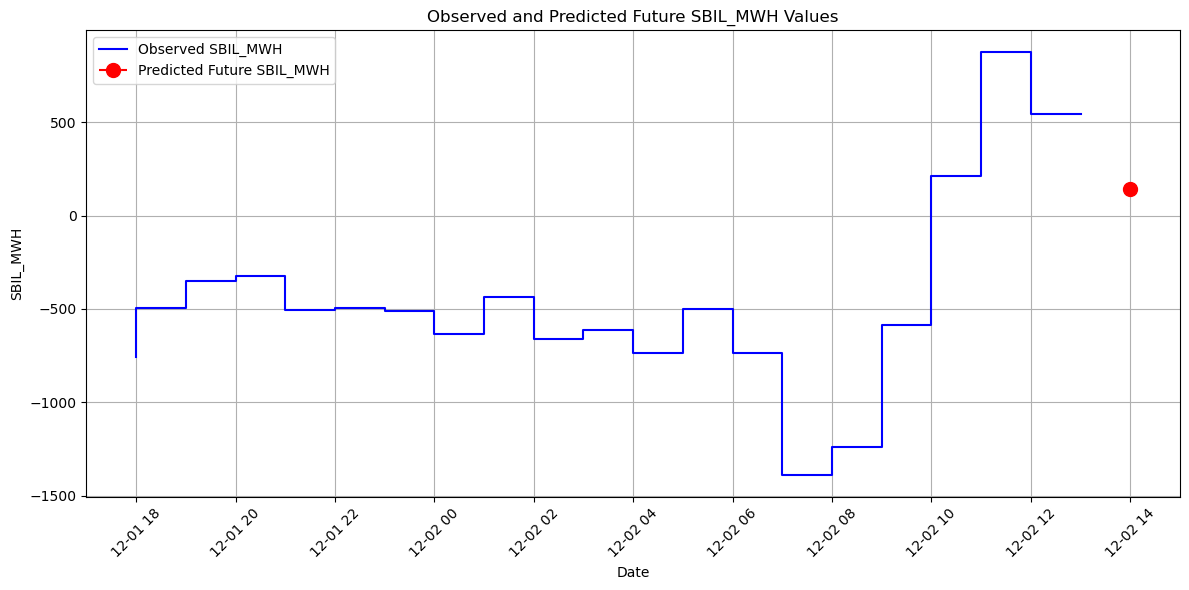

In [128]:
# Number of future steps you want to predict (set to 1 for the next step)
n_future_steps = 1

# Filter the rows where the target 'SBIL_MWH' is not NaN
valid_target_index = df_nord[~df_nord['SBIL_MWH'].isna()].index

# Get the last timestamp from the valid target index
last_timestamp = valid_target_index[-1]

# Get the most recent data from the test set to start the prediction
last_past = X_past_test[-1].reshape(1, -1)   # Last known past covariates
last_future = X_future_test[-1].reshape(1, -1)  # Last known future covariates
last_present = X_present_test[-1].reshape(1, -1)  # Last known present covariates

# Normalize the data for prediction
last_past_norm = scaler_X_past.transform(last_past)
last_future_norm = scaler_X_future.transform(last_future)
last_present_norm = scaler_X_present.transform(last_present)

# Combine the last known values as the input for prediction
last_input = np.concatenate([last_past_norm, last_future_norm, last_present_norm], axis=1)

# Predict the next time step (one value)
next_value = model1.predict(last_input)

# Inverse transform the predicted value to get it back to the original scale
next_value_orig = scaler_y.inverse_transform(next_value.reshape(-1, 1)).flatten()[0]

# Append the predicted value to the list (for future plotting)
predicted_values = [next_value_orig]

# Add one hour to the timestamp to predict the next time step
next_timestamp = last_timestamp + pd.Timedelta(hours=1)
future_dates = [next_timestamp]

# Create a DataFrame to store the predicted future value
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_SBIL_MWH': predicted_values
})

# Get the last `n` actual observations (from the test set) for plotting
n_last_obs = 20  # For example, plot the last 20 observed values
last_observed_df = pd.DataFrame({
    'Date': valid_target_index[-n_last_obs:],
    'Actual_SBIL_MWH': scaler_y.inverse_transform(y_test[-n_last_obs:].reshape(-1, 1)).flatten()
})

# Plot the last observed values and the predicted future value
plt.figure(figsize=(12, 6))

# Plot observed values
plt.step(last_observed_df['Date'], last_observed_df['Actual_SBIL_MWH'], label='Observed SBIL_MWH', color='blue')

# Plot predicted value with a large point
plt.plot(future_df['Date'], future_df['Predicted_SBIL_MWH'], label='Predicted Future SBIL_MWH', color='red', linestyle='--', marker='o', markersize=10)

# Add labels and title
plt.title('Observed and Predicted Future SBIL_MWH Values')
plt.xlabel('Date')
plt.ylabel('SBIL_MWH')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()



In [129]:
last_observed_df['Date']

0    2024-12-01 18:00:00
1    2024-12-01 19:00:00
2    2024-12-01 20:00:00
3    2024-12-01 21:00:00
4    2024-12-01 22:00:00
5    2024-12-01 23:00:00
6    2024-12-02 00:00:00
7    2024-12-02 01:00:00
8    2024-12-02 02:00:00
9    2024-12-02 03:00:00
10   2024-12-02 04:00:00
11   2024-12-02 05:00:00
12   2024-12-02 06:00:00
13   2024-12-02 07:00:00
14   2024-12-02 08:00:00
15   2024-12-02 09:00:00
16   2024-12-02 10:00:00
17   2024-12-02 11:00:00
18   2024-12-02 12:00:00
19   2024-12-02 13:00:00
Name: Date, dtype: datetime64[ns]

In [130]:
last_observed_df['Actual_SBIL_MWH']

0     -755.713
1     -492.768
2     -352.598
3     -324.464
4     -505.760
5     -495.682
6     -513.084
7     -635.701
8     -438.182
9     -663.813
10    -611.268
11    -735.972
12    -498.923
13    -737.221
14   -1391.967
15   -1241.300
16    -587.591
17     209.173
18     878.177
19     541.433
Name: Actual_SBIL_MWH, dtype: float64

In [131]:
future_df

,Date,Predicted_SBIL_MWH
0,2024-12-02 14:00:00,139.579681


In [132]:
import os
import pandas as pd
from datetime import datetime

# Assuming your existing DataFrame is stored in a CSV file (e.g., 'data.csv')
file_path = r'C:\imbalance_forecast\data\df_nord_h_future.csv'

# Step 1: Check if the file exists and is not empty
if os.path.exists(file_path) and os.stat(file_path).st_size > 0:
    # Read the existing DataFrame from the CSV file
    df_existing = pd.read_csv(file_path)
else:
    # If the file does not exist or is empty, create an empty DataFrame with the necessary columns
    df_existing = pd.DataFrame(columns=['Date', 'Predicted_SBIL_MWH', 'Run_Timestamp'])

# Step 2: Ensure the columns exist, and if the file is empty, create them
if df_existing.empty:
    df_existing = pd.DataFrame(columns=['Date', 'Predicted_SBIL_MWH', 'Run_Timestamp'])

# Step 3: Ensure the 'Date' column is in datetime format for proper comparison
df_existing['Date'] = pd.to_datetime(df_existing['Date'], errors='coerce')

# Step 4: Check if any existing data has the same 'Date' as in future_df
# Assuming future_df has only one new row to append
# Convert the 'Date' column in future_df to datetime if necessary
future_df['Date'] = pd.to_datetime(future_df['Date'], errors='coerce')

# Step 5: Handle duplicates by checking if the date already exists in df_existing
if future_df['Date'].iloc[0] in df_existing['Date'].values:
    # Replace the row with the same Date in df_existing
    df_existing.loc[df_existing['Date'] == future_df['Date'].iloc[0], 'Predicted_SBIL_MWH'] = future_df['Predicted_SBIL_MWH'].iloc[0]
    # Add a new timestamp when the data is updated
    df_existing.loc[df_existing['Date'] == future_df['Date'].iloc[0], 'Run_Timestamp'] = datetime.now()
else:
    # If the date does not exist, append the new row to df_existing
    future_df['Run_Timestamp'] = datetime.now()
    df_existing = pd.concat([df_existing, future_df], ignore_index=True)

# Step 6: Save the updated DataFrame back to the CSV file
df_existing.to_csv(file_path, index=False)

print("Data successfully appended or updated in the file.")

Data successfully appended or updated in the file.
